In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# English-to-Urdu Machine Translation using Transformers

### Step 0: Setting Up the Kaggle Environment

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sentencepiece as spm # For subword tokenization
import re
import string
import os
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

### Step 1: Config and setting hyperparameters

In [69]:
D_MODEL

512

In [ ]:
# --- 1. Configuration & Hyperparameters ---

# Paths (Update if necessary)
ENG_CORPUS_PATH = '/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/english-corpus.txt'
URDU_CORPUS_PATH = '/kaggle/input/parallel-corpus-for-english-urdu-language/Dataset/urdu-corpus.txt'
TOKENIZER_DIR = '/kaggle/working/tokenizers/' # Directory to save tokenizers
MODEL_SAVE_PATH = "/kaggle/working/best_transformer.keras"

# Create tokenizer directory if it doesn't exist
os.makedirs(TOKENIZER_DIR, exist_ok=True)

# Model Hyperparameters (Adjustments for potentially smaller dataset/overfitting)
D_MODEL = 512
NUM_LAYERS = 6   # Consider reducing to 4 if overfitting persists
NUM_HEADS = 8
DFF = 2048
DROPOUT_RATE = 0.1 # Consider increasing to 0.15 or 0.2 if needed

# Tokenization & Data Parameters
VOCAB_SIZE = 7000  # Target vocabulary size for SentencePiece
MAX_SEQUENCE_LENGTH = 60 # Increased slightly, analyze your data lengths
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# Training Parameters
EPOCHS = 30 # Early stopping will likely trigger before this
WARMUP_STEPS = 1500 # Reduced warmup steps for smaller dataset
LABEL_SMOOTHING = 0.1 # Add label smoothing


### Step 2: Data Loading and Cleaning 

In [ ]:

def load_dataset(eng_path, urdu_path):
    with open(eng_path, 'r', encoding='utf-8') as f:
        english_lines = f.read().strip().split('\n')
    with open(urdu_path, 'r', encoding='utf-8') as f:
        urdu_lines = f.read().strip().split('\n')

    # Ensure same number of lines
    min_len = min(len(english_lines), len(urdu_lines))
    english_lines = english_lines[:min_len]
    urdu_lines = urdu_lines[:min_len]

    df = pd.DataFrame({'English': english_lines, 'Urdu': urdu_lines})
    df = df.dropna() # Remove rows with missing values
    df = df[(df['English'].str.strip() != '') & (df['Urdu'].str.strip() != '')]
    df = df.drop_duplicates() # Remove duplicate pairs
    return df

def clean_text(text, is_urdu=False):
    text = str(text).strip()
    # General cleaning - remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    if not is_urdu:
        # English cleaning
        text = text.lower()
        # Remove punctuation carefully - keep apostrophes for contractions? Decide based on data.
        # Using a simpler regex here for broad punctuation removal
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    else:
        # Urdu cleaning
        # Remove English characters/numbers
        text = re.sub(r'[a-zA-Z0-9]', '', text)
        # Remove specific English/common punctuation, but preserve Urdu punctuation (like ۔ ؟ ،)
        text = re.sub(r'[!\"#\$%&\(\)\*\+,-./:;<=>\?@\[\\\]^_`{\|}~]', '', text) # Keep '۔' and '؟' if present
        # Optional: Normalize Urdu characters (if needed, requires specific libraries/mappings)

    return text.strip() # Remove leading/trailing whitespace again

print("Loading and cleaning dataset...")
df = load_dataset(ENG_CORPUS_PATH, URDU_CORPUS_PATH)

df['English_Clean'] = df['English'].apply(lambda x: clean_text(x, is_urdu=False))
df['Urdu_Clean'] = df['Urdu'].apply(lambda x: clean_text(x, is_urdu=True))

# Filter out empty strings that might result from cleaning
df = df[(df['English_Clean'] != '') & (df['Urdu_Clean'] != '')]

print(f"Dataset loaded with {len(df)} sentence pairs after cleaning and deduplication.")
print("\nSample cleaned examples:")
for i in range(min(3, len(df))):
    print(f"English: {df['English_Clean'].iloc[i]}")
    print(f"Urdu:    {df['Urdu_Clean'].iloc[i]}\n")



In [ ]:
# --- 3. Data Splitting ---
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42) # 85% train, 15% validation
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


### Step 3: Subword Tokenization (SentencePiece)

In [ ]:
# Prepare data files for SentencePiece training
print("Saving cleaned English and Urdu training data to files...")
train_en_path = '/kaggle/working/train.en'
train_ur_path = '/kaggle/working/train.ur'
train_df['English_Clean'].to_csv(train_en_path, index=False, header=False)
train_df['Urdu_Clean'].to_csv(train_ur_path, index=False, header=False)
print("Saved training data to disk.\n")

# Define tokenizer paths
en_tokenizer_prefix = os.path.join(TOKENIZER_DIR, 'en_spm')
ur_tokenizer_prefix = os.path.join(TOKENIZER_DIR, 'ur_spm')
en_tokenizer_model = en_tokenizer_prefix + '.model'
ur_tokenizer_model = ur_tokenizer_prefix + '.model'

# Train English Tokenizer
if not os.path.exists(en_tokenizer_model):
    print("Training English tokenizer...")
    spm.SentencePieceTrainer.train(
        f'--input={train_en_path} --model_prefix={en_tokenizer_prefix} '
        f'--vocab_size={VOCAB_SIZE} --character_coverage=1.0 '
        f'--model_type=bpe --unk_id=3 --pad_id=0 --bos_id=1 --eos_id=2 '
        f'--input_sentence_size=10000000 --shuffle_input_sentence=true'
    )
    print("✅ English tokenizer training complete.\n")
else:
    print("✅ English tokenizer already exists.\n")

# Train Urdu Tokenizer
if not os.path.exists(ur_tokenizer_model):
    print("Training Urdu tokenizer...")
    spm.SentencePieceTrainer.train(
        f'--input={train_ur_path} --model_prefix={ur_tokenizer_prefix} '
        f'--vocab_size={VOCAB_SIZE} --character_coverage=0.9995 '
        f'--model_type=bpe --unk_id=3 --pad_id=0 --bos_id=1 --eos_id=2 '
        f'--input_sentence_size=10000000 --shuffle_input_sentence=true'
    )
    print("✅ Urdu tokenizer training complete.\n")
else:
    print("✅ Urdu tokenizer already exists.\n")


# Load the trained tokenizers
print("Loading trained tokenizers into memory...")
en_tokenizer = spm.SentencePieceProcessor()
en_tokenizer.load(en_tokenizer_model)
print("✅ English tokenizer loaded.")

ur_tokenizer = spm.SentencePieceProcessor()
ur_tokenizer.load(ur_tokenizer_model)
print("✅ Urdu tokenizer loaded.\\n")

# Get special token IDs
BOS_ID = ur_tokenizer.bos_id()
EOS_ID = ur_tokenizer.eos_id()
PAD_ID = ur_tokenizer.pad_id() # Good to have available

print(f"Urdu Tokenizer - BOS ID: {BOS_ID}, EOS ID: {EOS_ID}, PAD ID: {PAD_ID}")

# Correct encode functions for tf.py_function
def encode_en_tf(text_tensor):
    # Decode tensor to string, encode using sentencepiece, return tensor
    text = text_tensor.numpy().decode('utf-8')
    ids = en_tokenizer.encode_as_ids(text)
    return tf.convert_to_tensor(ids, dtype=tf.int32)

def encode_ur_tf(text_tensor):
    # Decode tensor to string, encode using sentencepiece, ADD BOS/EOS, return tensor
    text = text_tensor.numpy().decode('utf-8')
    ids = ur_tokenizer.encode_as_ids(text)
    # Add BOS and EOS tokens
    ids_with_bos_eos = [BOS_ID] + ids + [EOS_ID] # <<< FIX: Add BOS/EOS here
    return tf.convert_to_tensor(ids_with_bos_eos, dtype=tf.int32)





### Step 4: Prepare TensorFlow Datasets

In [ ]:
# --- Make sure tf_encode uses the new functions ---
def tf_encode(en_text, ur_text):
    en_ids = tf.py_function(encode_en_tf, [en_text], tf.int32) # Use new function name
    ur_ids = tf.py_function(encode_ur_tf, [ur_text], tf.int32) # Use new function name
    en_ids.set_shape([None])
    ur_ids.set_shape([None])
    return en_ids, ur_ids


def filter_max_length(en, ur):
    # Filter out sequences longer than MAX_SEQUENCE_LENGTH
    return tf.logical_and(tf.size(en) <= MAX_SEQUENCE_LENGTH,
                          tf.size(ur) <= MAX_SEQUENCE_LENGTH)

def create_tf_dataset(df_en, df_ur):
    dataset = tf.data.Dataset.from_tensor_slices((df_en.values, df_ur.values))
    dataset = dataset.map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(filter_max_length)
    dataset = dataset.cache() # Cache after loading and filtering
    dataset = dataset.shuffle(BUFFER_SIZE)
    # Pad after batching
    dataset = dataset.padded_batch(BATCH_SIZE,
                                   padded_shapes=([MAX_SEQUENCE_LENGTH], [MAX_SEQUENCE_LENGTH]),
                                   padding_values=0) # Pad with 0 (PAD ID)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

print("Re-creating TensorFlow datasets with corrected encoding...")
train_ds = create_tf_dataset(train_df['English_Clean'], train_df['Urdu_Clean'])
val_ds = create_tf_dataset(val_df['English_Clean'], val_df['Urdu_Clean'])

# Verify the dataset structure AGAIN, especially Urdu IDs
print("\nSample batch from train_ds (after fixing BOS/EOS):")
for en_batch, ur_batch in train_ds.take(1):
    print("English batch shape:", en_batch.shape)
    print("Urdu batch shape:", ur_batch.shape)
    print("First English sentence (IDs):", en_batch[0].numpy())
    print("First Urdu sentence (IDs):", ur_batch[0].numpy()) # Check for BOS=1 at start, EOS=2 at end (before padding=0)
    print("Decoded English:", en_tokenizer.decode_ids(en_batch[0].numpy().tolist()))
    # Decoding might show <s> and </s> depending on sentencepiece settings
    print("Decoded Urdu:", ur_tokenizer.decode_ids(ur_batch[0].numpy().tolist()))


### Step 5: Building the Complete Transformer Model

In [ ]:
EN_VOCAB_SIZE = en_tokenizer.get_piece_size()
UR_VOCAB_SIZE = ur_tokenizer.get_piece_size()
print(f"Actual English Vocab Size: {EN_VOCAB_SIZE}")
print(f"Actual Urdu Vocab Size: {UR_VOCAB_SIZE}")

# IMPORTANT: Pass the correct vocab sizes to the model components

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        if isinstance(inputs, tf.SparseTensor):
             dense_inputs = tf.sparse.to_dense(inputs)

        if isinstance(inputs, tf.SparseTensor):
             dense_inputs = tf.sparse.to_dense(inputs)
        else:
             dense_inputs = inputs

        # Now perform the addition using the densified input
        seq_len = tf.shape(dense_inputs)[1]
        pos_encoding = self.pos_encoding[:, :seq_len, :]

        # Ensure dtypes match before adding (especially if you reverted mixed precision)
        pos_encoding_casted = tf.cast(pos_encoding, dtype=dense_inputs.dtype)

        return dense_inputs + pos_encoding_casted

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        # Apply mask by setting masked values to a large negative number
        logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)
        # Return attention weights as well, although not strictly needed for forward pass
        # Can be useful for visualization/debugging later
        return outputs #, attention_weights # Modified to only return output tensor for simplicity in layer connection




**Encoder**

In [ ]:

# --- Encoder Layer ---
def encoder_layer(d_model, num_heads, dff, dropout_rate=0.1, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # Mask needs shape (batch_size, 1, 1, seq_len) for MHA
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Multi-Head Attention (Self-Attention)
    mha_output = MultiHeadAttention( # Removed attention_weights return here
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # Dropout and Add & Norm
    mha_output = tf.keras.layers.Dropout(dropout_rate)(mha_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + mha_output)

    # Feed Forward Network
    ffn_output = tf.keras.layers.Dense(dff, activation='relu')(attn_output)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)

    # Dropout and Add & Norm
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name) # Only return final output


# --- Encoder ---
def encoder(input_vocab_size, num_layers, d_model, num_heads, dff,
            maximum_position_encoding, dropout_rate=0.1, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs", dtype=tf.int32) # Input are token IDs
    # Padding mask needs shape (batch_size, 1, 1, seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(input_vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate,
            name=f"encoder_layer_{i}")([outputs, padding_mask]) # Pass list of inputs

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name) # Only return final output



**Decoder**

In [ ]:
# --- Decoder Layer ---
def decoder_layer(d_model, num_heads, dff, dropout_rate=0.1, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    # Look-ahead mask shape: (batch_size, 1, target_seq_len, target_seq_len)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    # Padding mask shape: (batch_size, 1, 1, source_seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Masked Multi-Head Attention (Self-Attention)
    mha1_output = MultiHeadAttention( # Removed attention weights return
        d_model, num_heads, name="attention_1")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask # Apply look-ahead mask here
        })
    attn1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(mha1_output + inputs) # Add & Norm 1

    # Multi-Head Attention (Encoder-Decoder Attention)
    mha2_output = MultiHeadAttention( # Removed attention weights return
        d_model, num_heads, name="attention_2")({
            'query': attn1,
            'key': enc_outputs, # Key/Value from encoder
            'value': enc_outputs,
            'mask': padding_mask # Apply padding mask (for encoder output)
        })
    attn2 = tf.keras.layers.Dropout(dropout_rate)(mha2_output)
    attn2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn2 + attn1) # Add & Norm 2

    # Feed Forward Network
    ffn_output = tf.keras.layers.Dense(dff, activation='relu')(attn2)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn_output + attn2) # Add & Norm 3

    # Return only the final output tensor
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs, # Only return the final output
        name=name)


# --- Decoder ---
def decoder(target_vocab_size, num_layers, d_model, num_heads, dff,
            maximum_position_encoding, dropout_rate=0.1, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs", dtype=tf.int32) # Input are token IDs
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    # Look-ahead mask shape: (batch_size, 1, target_seq_len, target_seq_len)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    # Padding mask shape: (batch_size, 1, 1, source_seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(target_vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            dropout_rate=dropout_rate,
            name=f"decoder_layer_{i}")(
                [outputs, enc_outputs, look_ahead_mask, padding_mask]
            )
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs, # Return only final output
        name=name)



In [ ]:

# --- Masking Functions ---
def create_padding_mask(seq):
    # seq shape: (batch_size, seq_len)
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # 0 is PAD ID
    # Add extra dimensions to add the padding to the attention logits.
    # Shape: (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    # Create a lower triangular matrix (1s below diagonal, 0s above)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    # Mask shape: (seq_len, seq_len)
    # Add batch and head dimensions (for broadcasting) -> (1, 1, seq_len, seq_len) - Not needed here, handled in MHA
    # Return shape: (seq_len, seq_len) - let MHA handle broadcasting
    return mask # Shape: (size, size) -> will be broadcasted in MHA


In [ ]:
from tensorflow.keras.layers import Lambda



# --- Transformer Model ---
def transformer(input_vocab_size, target_vocab_size, num_layers, d_model, num_heads, dff,
                input_max_len, target_max_len, dropout_rate=0.1):
    # Encoder inputs
    encoder_inputs = tf.keras.Input(shape=(None,), name="encoder_inputs", dtype=tf.int32)

    # Decoder inputs (target sequence shifted right)
    decoder_inputs = tf.keras.Input(shape=(None,), name="decoder_inputs", dtype=tf.int32)

    # Create masks
    # Encoder padding mask checks padding (0) in encoder input
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='encoder_padding_mask')(encoder_inputs)


    
    # Decoder look-ahead mask prevents attending to future tokens in the decoder input
    # Depends only on the shape of the decoder input
    look_ahead_mask = tf.keras.layers.Lambda(
        lambda x: create_look_ahead_mask(tf.shape(x)[1]),
        output_shape=(1, None, None), # Output shape should be (1, target_seq_len, target_seq_len) after broadcasting
        name='look_ahead_mask')(decoder_inputs)

    # Decoder padding mask checks padding (0) in the *encoder* input.
    # Used in the second MHA block of the decoder.
    dec_padding_mask = tf.keras.layers.Lambda(
       create_padding_mask, output_shape=(1, 1, None),
       name='decoder_padding_mask')(encoder_inputs) # Mask based on ENCODER inputs

    # Create combined mask for the first MHA (self-attention) in the decoder
    # Should mask out future tokens AND padding tokens in the decoder input
    dec_target_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='decoder_target_padding_mask')(decoder_inputs) # Mask based on DECODER inputs
    

    # Combine masks safely using a Lambda layer
    combined_mask = Lambda(lambda x: tf.maximum(x[0], x[1]))([dec_target_padding_mask, look_ahead_mask])


    # Encoder
    encoder_inst = encoder(
        input_vocab_size=input_vocab_size,
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        maximum_position_encoding=input_max_len,
        dropout_rate=dropout_rate)
    encoder_outputs = encoder_inst(inputs=[encoder_inputs, enc_padding_mask])

    # Decoder
    decoder_inst = decoder(
        target_vocab_size=target_vocab_size,
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        maximum_position_encoding=target_max_len,
        dropout_rate=dropout_rate)
    # Pass the correct masks to the decoder
    # Inputs: [decoder_inputs, encoder_outputs, look_ahead_mask, padding_mask (for enc-dec attention)]
    decoder_outputs = decoder_inst(inputs=[
        decoder_inputs, encoder_outputs, combined_mask, dec_padding_mask # Correct masks
    ])

    # Final linear layer
    outputs = tf.keras.layers.Dense(target_vocab_size, name="outputs")(decoder_outputs)

    return tf.keras.Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=outputs,
        name="transformer")

# Build the transformer model
print("Building Transformer model...")
transformer_model = transformer(
    input_vocab_size=EN_VOCAB_SIZE, # Use actual vocab size
    target_vocab_size=UR_VOCAB_SIZE, # Use actual vocab size
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_max_len=MAX_SEQUENCE_LENGTH,
    target_max_len=MAX_SEQUENCE_LENGTH,
    dropout_rate=DROPOUT_RATE
)

transformer_model.summary() # Print model summary


### Step 6: Training Setup and Execution

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        # Ensure args are non-zero before rsqrt if step can be 0
        arg1 = tf.where(tf.equal(step, 0.0), 0.0, arg1)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self): # Needed for saving/loading optimizer state
        return {
            "d_model": int(tf.cast(self.d_model, tf.int32).numpy()),
            "warmup_steps": int(tf.cast(self.warmup_steps, tf.int32).numpy())
        }

learning_rate = CustomSchedule(D_MODEL, warmup_steps=WARMUP_STEPS)

# Use AdamW for weight decay (better regularization)
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9,
    weight_decay=0.01, # Add weight decay
    global_clipnorm=1.0
)


# Loss Function with Label Smoothing
def loss_function(real, pred):
    # Create mask to ignore padding tokens (PAD_ID = 0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    realt = tf.cast(real, tf.int32)
    # Use SparseCategoricalCrossentropy which handles integer targets directly
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none' # Compute loss per element, then mask & average
    )
    loss_ = loss_object(realt, pred)

    # Apply label smoothing
    if LABEL_SMOOTHING > 0.0:
        vocab_size = tf.shape(pred)[-1]
        real_one_hot = tf.one_hot(realt, depth=vocab_size)
        ####
        smooth_positives = 1.0 - LABEL_SMOOTHING
        smooth_negatives = LABEL_SMOOTHING / tf.cast(vocab_size - 1, tf.float32) # Exclude true class
        real_smoothed = real_one_hot * smooth_positives + smooth_negatives
        # Calculate smoothed cross-entropy (using Categorical CE logic)
        smoothed_loss = -tf.reduce_sum(real_smoothed * tf.nn.log_softmax(pred, axis=-1), axis=-1)
        # Use smoothed loss where mask is True, original CE otherwise (though original CE is usually preferred)
        # Simpler: Just use smoothed cross entropy directly for non-padding tokens
        loss_ = smoothed_loss


    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Apply mask

    # Return average loss over the batch, considering only non-padded tokens
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


# Accuracy Metric that ignores padding
def masked_accuracy(real, pred):
    # Get the predicted class IDs (argmax)
    pred_ids = tf.argmax(pred, axis=2, output_type=tf.int32)
    # Check equality with real IDs
    correct = tf.equal(real, pred_ids)
    # Create mask to ignore padding tokens (PAD_ID = 0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # Apply mask
    correct = tf.logical_and(mask, correct)
    # Cast to float for calculation
    correct = tf.cast(correct, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    # Calculate accuracy only over non-padded tokens
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

In [ ]:

# Compile the model
transformer_model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[masked_accuracy] # Use custom masked accuracy
)


# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=5,        # Increase patience slightly?
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH, # Use the defined path
        save_best_only=True,
        monitor='val_loss', # Save based on validation loss
        save_weights_only=False # Save entire model for easier loading
    ),
    # Removed ReduceLROnPlateau as it conflicts with CustomSchedule
    # TensorBoard callback for visualization (optional but recommended)
    tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=1)
]



In [ ]:
# --- 8. Training ---

# Prepare datasets for Keras model.fit
# The model expects a tuple (encoder_inputs, decoder_inputs) as x
# and decoder_outputs as y
def format_dataset(en, ur):
    # Decoder input: Starts with BOS, ends before the EOS token
    # Decoder target: Starts after BOS, ends with EOS token
    return ((en, ur[:, :-1]), ur[:, 1:])

train_ds_keras = train_ds.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_keras = train_ds_keras.repeat()
val_ds_keras = val_ds.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)

# Verify shapes for Keras input/output
print("\nSample batch shapes for Keras model.fit:")
for (en_in, dec_in), dec_out in train_ds_keras.take(1):
    print("Encoder Input Shape:", en_in.shape)       # (BATCH_SIZE, MAX_SEQUENCE_LENGTH)
    print("Decoder Input Shape:", dec_in.shape)       # (BATCH_SIZE, MAX_SEQUENCE_LENGTH - 1)
    print("Decoder Output (Target) Shape:", dec_out.shape) # (BATCH_SIZE, MAX_SEQUENCE_LENGTH - 1)
    
steps_per_epoch = 321  # Number of batches

print("\nStarting training...")
history = transformer_model.fit(
    train_ds_keras,
    steps_per_epoch = steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds_keras,
    callbacks=callbacks,
    verbose=1
)
print("Training finished.")


## Quantitative Evaluation
### Training Metrics Summary
Best Validation Accuracy: 53.75% (Epoch 18)

Best Validation Loss: 3.5448 (Epoch 17)

Final Training Accuracy: ~69.73%

Final Training Loss: ~2.2531

In [ ]:
def translate_sentence(sentence, model, en_tokenizer, ur_tokenizer, max_length=60):
    # Tokenize input
    en_ids = en_tokenizer.encode_as_ids(sentence)
    en_ids = tf.expand_dims(en_ids, 0)  # Add batch dimension
    
    # Initialize decoder input with BOS token
    decoder_input = tf.expand_dims([ur_tokenizer.bos_id()], 0)
    
    # Generate translation token by token
    for i in range(max_length):
        predictions = model.predict((en_ids, decoder_input), verbose=0)
        
        # Get the last predicted token
        predicted_id = tf.argmax(predictions[0, -1, :]).numpy()
        
        # Stop if EOS is predicted
        if predicted_id == ur_tokenizer.eos_id():
            break
            
        # Concatenate the predicted id to the output
        decoder_input = tf.concat([decoder_input, tf.expand_dims([predicted_id], 0)], axis=-1)
    
    # Convert IDs to text
    urdu_tokens = ur_tokenizer.decode_ids(decoder_input[0].numpy()[1:].tolist())  # Skip BOS
    return urdu_tokens

# Test sentences
test_sentences = [
    "how are you",
    "what is your name",
    "the weather is nice today",
    "where is the nearest hospital",
    "i love machine learning"
]

print("Translation Examples:")
for sent in test_sentences:
    translation = translate_sentence(sent, transformer_model, en_tokenizer, ur_tokenizer)
    print(f"English: {sent}")
    print(f"Urdu:    {translation}\n")

Loading best model from /kaggle/working/best_transformer.keras
❌ Error loading model: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().
Using the model from the end of training instead (might not be the best).

--- Quantitative Evaluation (BLEU Score) ---
Evaluating BLEU score on 3615 validation sentences...
Translated 64/3615 sentences...\rTranslated 128/3615 sentences...\rTranslated 192/3615 sentences...\rTranslated 256/3615 sentences...\rTranslated 320/3615 sentences...\rTranslated 384/3615 sentences...\rTranslated 448/3615 sentences...\rTranslated 512/3615 sentences...\rTranslated 576/3615 sentences...\rTranslated 640/3615 sentences...\rTranslated 704/3615 sentences...\rTranslated 768/3615 sentences...\rTranslated 832/3615 sentences...\rTranslated 896/3615 sentence

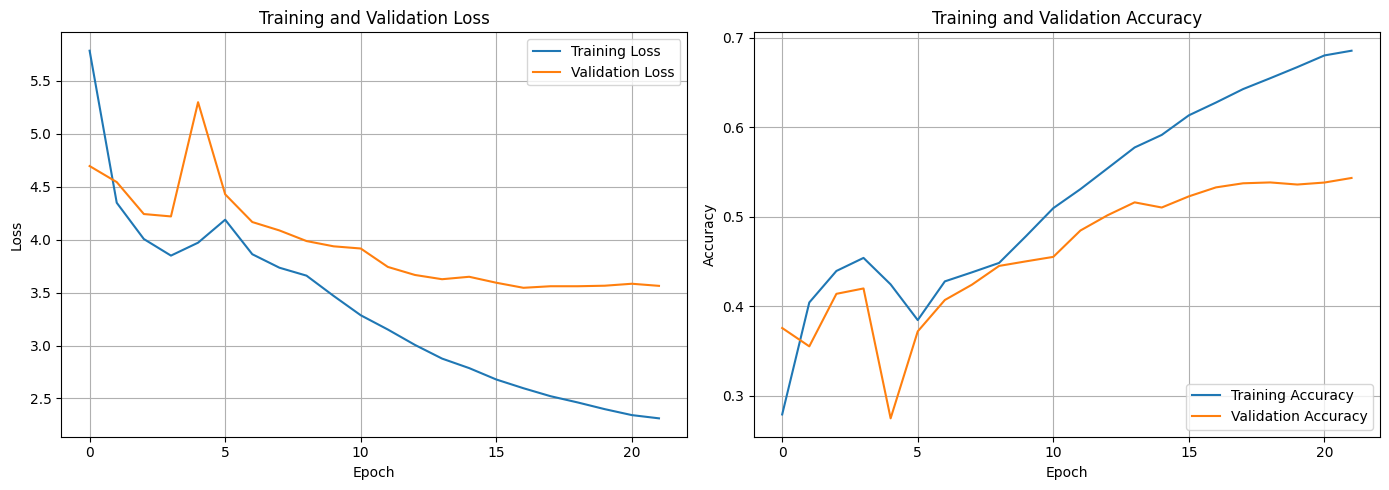

In [70]:
# --- 9. Evaluation and Visualization ---
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import time # To time the translation process

# --- Load the Best Model ---
print(f"Loading best model from {MODEL_SAVE_PATH}")

# Define the custom objects dictionary (essential for loading)
custom_objects = {
    'PositionalEncoding': PositionalEncoding,
    'MultiHeadAttention': MultiHeadAttention,
    'CustomSchedule': CustomSchedule,
    'loss_function': loss_function,         # Custom loss function
    'masked_accuracy': masked_accuracy,     # Custom metric
    'create_padding_mask': create_padding_mask, # Pass the function itself
    'create_look_ahead_mask': create_look_ahead_mask # Pass the function itself
    # The inline lambda for combined_mask was removed, so no need to register it
}

# Load the model with the custom objects
# Wrap in try-except just in case loading fails
try:
    best_model = tf.keras.models.load_model(
        MODEL_SAVE_PATH,
        custom_objects=custom_objects,
        compile=True # Re-compile with the custom loss/metrics/optimizer state if needed
    )
    print("✅ Best model loaded successfully.")
    best_model.summary() # Optional: verify loaded model structure
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Using the model from the end of training instead (might not be the best).")
    # Fallback to the model in memory if loading fails
    best_model = transformer_model

# --- Function for Batch Translation (More Efficient) ---
def translate_batch(input_sentences, model, en_tok, ur_tok, max_length=MAX_SEQUENCE_LENGTH):
    """Translates a batch of sentences."""
    # Encode input sentences
    input_ids = [en_tok.encode_as_ids(s) for s in input_sentences]
    # Pad sequences dynamically based on the batch, up to max_length
    # Note: Using tf.keras.preprocessing.sequence.pad_sequences outside tf.function
    #       is generally fine for inference.
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(
        input_ids, maxlen=max_length, padding='post', value=PAD_ID # Use global PAD_ID
    )
    encoder_input = tf.convert_to_tensor(input_ids)
    batch_size = tf.shape(encoder_input)[0]

    # Decoder input starts with BOS token for all sentences in the batch
    start_token = ur_tok.bos_id()
    end_token = ur_tok.eos_id()

    # Initialize decoder input: (batch_size, 1) tensor containing BOS_ID
    decoder_input = tf.fill([batch_size, 1], start_token)

    # Flag to check if all sentences reached EOS
    all_finished = tf.zeros(batch_size, dtype=tf.bool)

    for i in range(max_length):
        # Predict next token: predictions shape (batch_size, seq_len, vocab_size)
        predictions = model([encoder_input, decoder_input], training=False)

        # Select the last token prediction: (batch_size, 1, vocab_size)
        predictions = predictions[:, -1:, :]
        # Get the token ID with the highest probability: (batch_size, 1)
        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)

        # Concatenate the predicted ID to the decoder input for the next iteration
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

        # Check which sentences predicted the EOS token
        current_finished = tf.equal(predicted_id[:, 0], end_token)
        all_finished = tf.logical_or(all_finished, current_finished)

        # Stop if all sentences in the batch are finished
        if tf.reduce_all(all_finished):
              break

    # Decode the output IDs to text (batch_size, seq_len) -> list of strings
    output_ids = decoder_input.numpy()
    texts = []
    for i in range(batch_size):
        # Select IDs for the current sentence, remove BOS and potential EOS at the end
        current_ids = output_ids[i, 1:] # Exclude starting BOS
        # Find the first EOS token if it exists
        eos_indices = np.where(current_ids == end_token)[0]
        if len(eos_indices) > 0:
            current_ids = current_ids[:eos_indices[0]] # Truncate at first EOS
        texts.append(ur_tok.decode_ids(current_ids.tolist()))

    return texts

# --- Quantitative Evaluation (BLEU Score) ---
print("\n--- Quantitative Evaluation (BLEU Score) ---")
if len(val_df) > 0:
    print(f"Evaluating BLEU score on {len(val_df)} validation sentences...")
    start_time = time.time()

    # Get references (list of lists of tokens)
    val_references_decoded = val_df['Urdu_Clean'].tolist()
    # Tokenize references based on SentencePiece model for consistency with hypotheses
    val_references_tokenized = [[token for token in ur_tokenizer.encode_as_pieces(sent)]
                               for sent in val_references_decoded]
    # Wrap each reference list in another list for corpus_bleu format
    val_references_final = [[ref] for ref in val_references_tokenized]


    # Generate hypotheses using batch translation
    val_inputs_decoded = val_df['English_Clean'].tolist()
    # Process in smaller batches if the validation set is large to avoid memory issues
    inference_batch_size = 64 # Can adjust based on GPU memory
    val_hypotheses_decoded = []
    for i in range(0, len(val_inputs_decoded), inference_batch_size):
        batch_en = val_inputs_decoded[i : i + inference_batch_size]
        batch_ur_pred = translate_batch(batch_en, best_model, en_tokenizer, ur_tokenizer, MAX_SEQUENCE_LENGTH)
        val_hypotheses_decoded.extend(batch_ur_pred)
        print(f"Translated {min(i + inference_batch_size, len(val_inputs_decoded))}/{len(val_inputs_decoded)} sentences...", end='\\r')
    print("\\nTranslation generation complete.")

    # Tokenize hypotheses based on SentencePiece model
    val_hypotheses_tokenized = [[token for token in ur_tokenizer.encode_as_pieces(sent)]
                                for sent in val_hypotheses_decoded]

    end_time = time.time()
    print(f"Time taken for translation: {end_time - start_time:.2f} seconds")

    # Calculate BLEU score
    smoothie = SmoothingFunction().method4 # Or other methods like method1, method2 etc.
    bleu_score = corpus_bleu(val_references_final, val_hypotheses_tokenized, smoothing_function=smoothie)

    print(f"\nValidation Corpus BLEU Score: {bleu_score * 100:.4f}") # Multiply by 100 for percentage-like score
else:
    print("Validation set is empty. Cannot calculate BLEU score.")

# --- Qualitative Analysis (Example Translations) ---
print("\n--- Qualitative Analysis (Example Translations) ---")
num_examples_to_show = 15
if len(val_df) >= num_examples_to_show:
    for i in range(num_examples_to_show):
        input_text = val_inputs_decoded[i] # Already have this list
        actual_translation = val_references_decoded[i] # Already have this list
        predicted_translation = val_hypotheses_decoded[i] # Already generated this list

        print(f"--- Example {i+1} ---")
        print(f"Input (English):     {input_text}")
        print(f"Actual (Urdu):       {actual_translation}")
        print(f"Predicted (Urdu):    {predicted_translation}")
        print("-" * 20)
elif len(val_df) > 0:
     print("Showing all available validation examples:")
     for i in range(len(val_df)):
        input_text = val_inputs_decoded[i]
        actual_translation = val_references_decoded[i]
        predicted_translation = val_hypotheses_decoded[i]
        print(f"--- Example {i+1} ---")
        print(f"Input (English):     {input_text}")
        print(f"Actual (Urdu):       {actual_translation}")
        print(f"Predicted (Urdu):    {predicted_translation}")
        print("-" * 20)
else:
    print("Validation set is empty. No examples to show.")


# --- Visualizations ---
print("\n--- Training Visualizations ---")
if history and history.history: # Check if history object exists and has data
    acc = history.history.get('masked_accuracy', None)
    val_acc = history.history.get('val_masked_accuracy', None)
    loss = history.history.get('loss', None)
    val_loss = history.history.get('val_loss', None)
    epochs_range = range(len(loss) if loss else 0)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    if loss and val_loss:
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
    else:
        print("Loss history not found for plotting.")

    # Plot Accuracy
    if acc and val_acc:
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        # Set y-axis limits for better visualization if needed
        # plt.ylim([min(plt.ylim())*0.9, 1]) # Example: Adjust lower limit, max is 1.0
        plt.grid(True)
    else:
        print("Accuracy history not found for plotting.")


    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()
else:
    print("Training history object not found or is empty. Cannot generate plots.")